# Structural cereal model

ReviewNB link: https://app.reviewnb.com/orianebro/PhD_Oriane/blob/main/structural_cereal_model.ipynb

In [1]:
#| echo: false

# Ignore warning about depreciated modules
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
#| echo: false

# Enable interactive plotting
# %matplotlib ipympl

In [3]:
# Deep reload

In this section, we define a static structural model for cereals.  
The paragraphs are organized so that it is easy to see how the model is built and how we can play with parameters.  

Some 3D plots are interactive, don't hesitate to rotate them.

## Create a parametric leaf

The leaf blade is represented as a surface.  
A parametric leaf is here defined by sample points (here 12), described by two sets of coordinates:  
- $(x,y)$: coordinates for the midrib in a vertical plane, give the curvature of the leaf;  
- $(s,r)$: curviliear abcissa (i.e. length along midrib) and relative length-dependent leaf width.

Note that $s$ can be expressed as a function of $x$ and $y$, at point $p \neq 0$, as follows: $ s_p(x,y) = \sqrt{(x_p-x_{p-1})^2+(y_p-y_{p-1})^2} $.  

The origin represents the leaf base.  

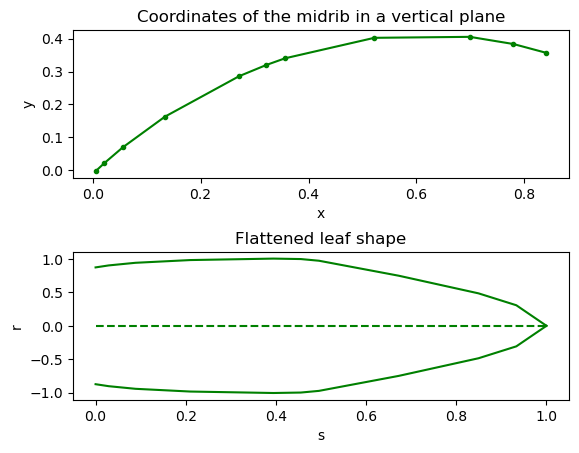

In [4]:
## Imports

# from installed packages
import numpy as np
import matplotlib.pyplot as plt
from heapq import *
from scipy.interpolate import splprep, splev
# from scipy.integrate import simps, trapz
from openalea.plantgl.all import Vector3

# from openalea.openalea.archicrop
from openalea.archicrop.cereal_leaf import leaf_shape_perez, sr_prevot, parametric_cereal_leaf
from openalea.archicrop.fitting import fit2, fit3, simplify, curvilinear_abscisse, distance, cost

## Code for generating a parametric leaf for a cereal 
pl=parametric_cereal_leaf(nb_segment=10, insertion_angle=40, scurv=0.7, curvature=70, klig=0.6, swmax=0.55, f1=0.64, f2=0.92)

fig, (ax1, ax2) = plt.subplots(nrows=2) 
# fig.suptitle('Parametric leaf')

ax1.plot(pl[0], pl[1], '.-', c="green")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title("Coordinates of the midrib in a vertical plane")

ax2.plot(pl[2], pl[3], '-', c="green")
ax2.plot(pl[2], -pl[3], '-', c="green")
ax2.plot(np.arange(0,1.1,0.1), np.zeros(11), c="green", ls="dashed")
ax2.set_xlabel('s')
ax2.set_ylabel('r')
ax2.set_title("Flattened leaf shape")

plt.subplots_adjust(hspace=0.5)

plt.show()

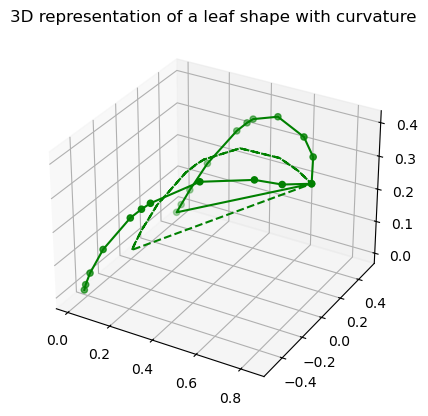

In [5]:
## Imports

# from installed packages
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp2d
import matplotlib.tri as mtri

# from openalea.archicrop
from openalea.archicrop.fitting import leaf_to_mesh_2d

## Code for representing the parametric leaf in 3D (ignore excess lines)
x=pl[0]
y=pl[1]
s=pl[2]
r=pl[3]

pts,ind=leaf_to_mesh_2d(x, y, r)

xs=[pt[0] for pt in pts]
ys=[pt[1] for pt in pts]
zs=[pt[2] for pt in pts]
    
X,Y=np.meshgrid(xs, ys)

tri=mtri.Triangulation(xs, ys)

fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(xs,ys,zs,c="green")
ax.plot(xs,ys,zs,c="green")
ax.plot(xs,np.zeros(len(ys)),zs,c="green",ls="dashed")
ax.set_title("3D representation of a leaf shape with curvature")
plt.show()

Please ignore excess straight lines.

## A cereal leaf

In [6]:
# from openalea.archicrop
from openalea.archicrop.cereal_leaf import parametric_cereal_leaf
from openalea.archicrop.geometry import leaf_mesh, stem_mesh

def simple_leaf(leaf, ratio):
    total_length = 80
    lw_ratio = 7.0

    L_shape = total_length
    Lw_shape = total_length / lw_ratio
    length = total_length * ratio
    s_base = 0
    s_top = 1.0

    return leaf_mesh(leaf, L_shape, Lw_shape, length, s_base, s_top)


In [45]:
from openalea.plantgl.all import Vector3, Material, Shape
from oawidgets.plantgl import *
%gui qt

# leaf = parametric_leaf(insertion_angle=30, scurv=0.6, curvature=130, alpha=-2.3)
leaf = parametric_cereal_leaf(insertion_angle=0, scurv=0.7, curvature=0, klig=0.6, swmax=0.55, f1=0.64, f2=0.92)
mesh_leaf = simple_leaf(leaf, 1) 
m = Material(Color3(0,80,0))
shape_leaf = Shape(mesh_leaf,m)
Viewer.display(shape_leaf)

# 326400

# elevation, azimuth, angle, etc to 0

## An internode

In [46]:
mesh_stem = stem_mesh(length=1, visible_length=1, stem_diameter=0.12)
shape_stem = Shape(mesh_stem,m)
Viewer.display(shape_stem)

## A phytomer = leaf + internode

## An axis

## A whole cereal plant

## Generate leaf azimuth series

Leaves grow around an axis with a given phyllotaxy, represented here as an angle from leaf to leaf (e.g. spiral with a given angle or alternate distichous = $180^o$).  

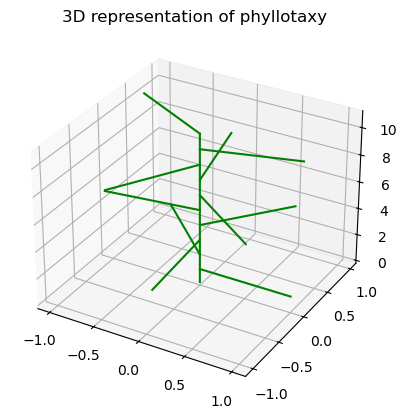

In [9]:
## Imports

# from installed packages 
# from itertools import cycle

# from openalea.archicrop
from openalea.archicrop.plant import leaf_azimuth

## Code for generating leaf azimuths series for a given phyllotaxy
nb_phy=10
phyllotactic_angle=137
spiral=True
phyllotactic_deviation=0
plant_orientation=0

la=leaf_azimuth(size=nb_phy, 
                phyllotactic_angle=phyllotactic_angle, 
                phyllotactic_deviation=phyllotactic_deviation, 
                plant_orientation=plant_orientation, 
                spiral=spiral)

x=np.cos(la*np.pi/180)
y=np.sin(la*np.pi/180)
z=np.linspace(1,len(la)+1,len(la))

fig,ax=plt.subplots(subplot_kw=dict(projection='3d'))
for i,a in enumerate(la):
    ax.plot(np.linspace(0,x[i],2), np.linspace(0,y[i],2), [z[i],z[i]], c="green")
ax.plot([0,0], [0,0], [0,z[-1]], c="green")

ax.set_title("3D representation of phyllotaxy")

plt.show()

## Manage internode lengths

Internodes on an axis have varying lengths. The repartition of their lengths along the axis can be approximated with a geometric model.

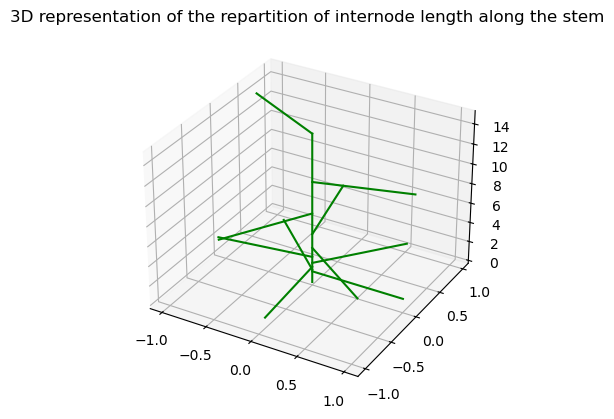

In [10]:
## Imports
from openalea.archicrop.cereal_plant import geometric_dist

## Code for applying lengths to internodes according to a geometric model
plant_height=15
q=1.5
u0=1

x=np.cos(la*np.pi/180)
y=np.sin(la*np.pi/180)
z=geometric_dist(height=plant_height, 
                   nb_phy=nb_phy, 
                   q=q,
                   u0=u0)

fig,ax=plt.subplots(subplot_kw=dict(projection='3d'))
for i,a in enumerate(la):
    ax.plot(np.linspace(0,x[i],2), np.linspace(0,y[i],2), [z[i],z[i]], c="green")
ax.plot([0,0], [0,0], [0,z[-1]], c="green")

ax.set_title("3D representation of the repartition of internode length along the stem")

plt.show()

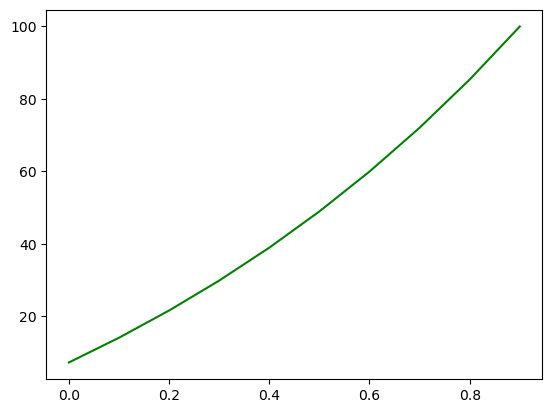

In [28]:
from openalea.archicrop.cereal_plant import geometric_dist

nb_phy = 10
height = 100

collar_heights_geom = geometric_dist(height, nb_phy, 1.1, u0)

plt.plot(np.arange(0, 1, 1/nb_phy), collar_heights_geom, color="green")
# plt.scatter(range(nb_phy), collar_heights_geom, color="green")
plt.show()

## Manage leaf lengths as a function of height

Leaves that grow on an axis have varying lengths. The repartition of their lengths along the axis can be approximated with a bell shaped model.

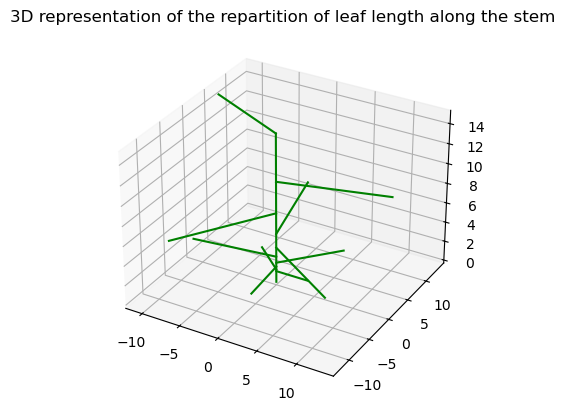

In [12]:
## Imports
from openalea.archicrop.cereal_plant import bell_shaped_dist

## Code for applying lengths to leaves according to a bell shaped model
leaf_area=100

bsd=bell_shaped_dist(leaf_area=leaf_area, 
                     nb_phy=nb_phy, 
                     rmax=.8, 
                     skew=0.15)

x=np.cos(la*np.pi/180)*bsd
y=np.sin(la*np.pi/180)*bsd
z=geometric_dist(height=plant_height, 
                   nb_phy=nb_phy, 
                   q=q, u0=u0)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
for i,a in enumerate(la):
    ax.plot(np.linspace(0,x[i],2), np.linspace(0,y[i],2), [z[i],z[i]], c="green")
ax.plot([0,0], [0,0], [0,z[-1]], c="green")

ax.set_title("3D representation of the repartition of leaf length along the stem")

plt.show()

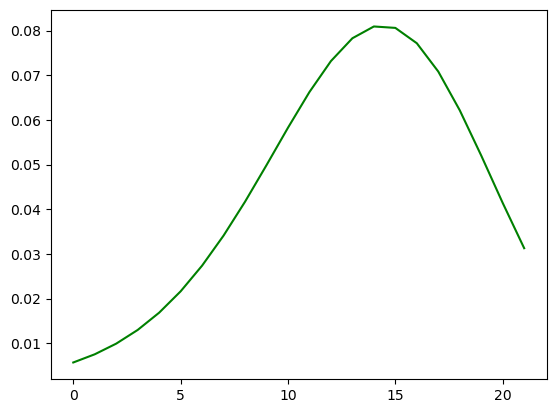

In [40]:
leaf_areas = bell_shaped_dist(leaf_area=1, nb_phy=22, rmax=0.7, skew=0.01)

plt.plot(range(len(leaf_areas)), leaf_areas, color="green")
plt.show()

## Arrange a leaf to be placed along a stem with a given inclination.

A leaf must undergo a translation to be placed against the surface of the stem (tangent to it), and a rotation to be tilted like the stem (inclination = 1 if main stem).

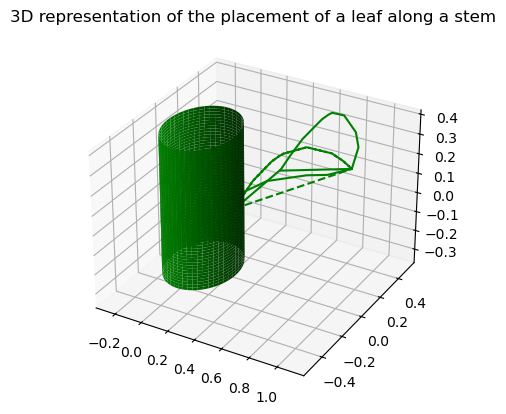

In [15]:
## Imports

# from installed packages
from math import pi, cos, sin, radians
import openalea.plantgl.all as pgl

# from openalea.archicrop
# from openalea.archicrop.cereals_leaf import arrange_leaf
# or 
from openalea.archicrop.leaf import arrange_leaf

## Code for placing a leaf against a stem element (here a cylinder), with a given inclination
stem_diameter=0.5
inclination=1

al=arrange_leaf(leaf=pl, 
                stem_diameter=stem_diameter, 
                inclination=inclination, 
                relative=True)

x=al[0]
y=al[1]
s=al[2]
r=al[3]

pts,ind=leaf_to_mesh_2d(x, y, r)

xs=[pt[0] for pt in pts]
ys=[pt[1] for pt in pts]
zs=[pt[2] for pt in pts]
    
X,Y=np.meshgrid(xs, ys)

tri=mtri.Triangulation(xs, ys)

fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.plot(xs,ys,zs,c="green")
ax.plot([xs[0],xs[0]],[ys[0],-ys[0]],[0,0],c="green")
ax.plot(xs,np.zeros(len(ys)),zs,c="green",ls="dashed")

radius=stem_diameter/2
z=np.linspace(-zs[-1], zs[-1])
theta=np.linspace(0, 2*np.pi)
theta_grid, z_stem=np.meshgrid(theta, z)
x_stem=radius*np.cos(theta_grid)
y_stem=radius*np.sin(theta_grid)

ax.plot_surface(x_stem, y_stem, z_stem, color="green")

ax.set_title("3D representation of the placement of a leaf along a stem")

plt.show()

An MTG (Multiscale Tree Graph) is created as a representation of a parametrized cereal shoot.  
The different scales are: 
- Plant  
- Axis  
- Stem / Leaf   

The leaf lengths and widths follow the bell shaped curve described before.  
The first internode in the MTG actually corresponds to the pseudostem, i.e. the about 4 to 8 short first internodes that rapidly lose their leaves. The lengths following internodes follow the geometric model described before.

## Tillering / Branching

First, basipetal tillers, straight, oriented according to a certain angle, appearing according to a certain timing  

Parameters : number, maximal order, reduction factor, tiller appearance rate (>1 phyllochron or not? several mechanisms depending on species, keep it simple at first), insertion angle (same as leaf ?), tiller curvature, condition related to density (ex: hyp sorghum im field --> no tiller)

For the final structure: When visiting the phytomers from the base, the tillers will be allocated sequentially to the short internodes, following their age and, for a given age, following the ascending order of tiller order, in the limits of the total number of tillers and the maximal order allowed for tillers. Some geometrical features (length, stem diameter, max leaf length, etc.) will be reduced by a given reduction ratio (order-dependent ?). The angles of the tillers 

How do we manage the leaves of the short internodes bearing tillers ? Do we consider them at all ?  

For growth: the age (start_tt and end_tt) is determined by a tiller appearance rate, expressed as a function of the phyllochron (and the order ?)   

see weberpenn
Ecomeristem
Evers
Abichou